In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19 

from PIL import Image
import numpy as np 
from tqdm import tqdm 
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, 'src/')
from hrnet import HRNet
from utils import *
from args import get_parser

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
# Dummy class to model get_parser
class Args:
    def __init__(self):
        self.img_root = 'src/imgs'
        self.content_img = 'content1.png'
        self.style_img = 'style1.png'
        self.use_batch = False
        self.bs = 16
        self.use_gpu = True
        
args = Args()

In [3]:
if args.use_gpu:
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        raise Exception('GPU is not available')
else:
    device = torch.device('cpu')
    
# Load VGG19 features
vgg = vgg19(pretrained=True).features
vgg = vgg.to(device)
# We don't want to train VGG
for param in vgg.parameters():
    param.requires_grad_(False)
    
# Load style net
style_net = HRNet()
style_net = style_net.to(device)

torch.backends.cudnn.benchmark = True

In [5]:
content_img = load_image(os.path.join(args.img_root, args.content_img), size=500)
content_img = content_img.to(device)

style_img = load_image(os.path.join(args.img_root, args.style_img))
style_img = style_img.to(device)

In [6]:
content_img.size(), style_img.size()

(torch.Size([1, 3, 500, 500]), torch.Size([1, 3, 1067, 600]))

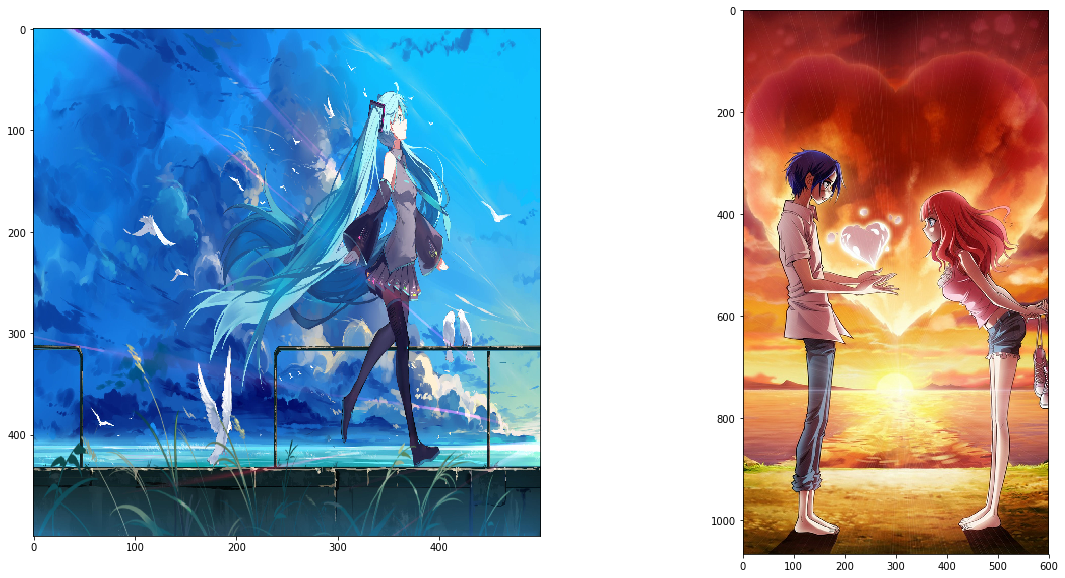

In [7]:
# Show content and style image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(im_convert(content_img))
ax2.imshow(im_convert(style_img))
plt.show()

In [8]:
# Get features from VGG19
content_features = get_features(content_img, vgg)
style_features = get_features(style_img, vgg)

style_gram_matrixs = {layer: get_gram_matrix(style_features[layer]) for layer in style_features}

target = content_img.clone().requires_grad_(True).to(device)

In [9]:
style_weights = {
     'conv1_1': 0.1,
     'conv2_1': 0.2,
     'conv3_1': 0.4,
     'conv4_1': 0.8,
     'conv5_1': 1.6
}

content_weight = 150
style_weight = 1

show_every = 100
optim = torch.optim.Adam(style_net.parameters(), lr=5e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=200, gamma=0.9)
steps = 1000

content_loss_epoch = []
style_loss_epoch = []
total_loss_epoch = []
output_image = content_img

  0%|          | 0/1001 [00:00<?, ?it/s]

After 0 criterions:
Total loss:  3410.68896484375
Content loss:  12.772430419921875
Style loss:  1494.824462890625


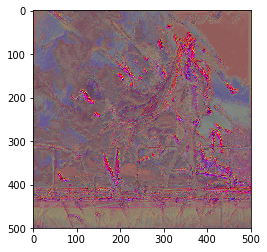

 10%|▉         | 100/1001 [01:30<12:37,  1.19it/s]

After 100 criterions:
Total loss:  711.39501953125
Content loss:  2.4451608657836914
Style loss:  344.6208801269531


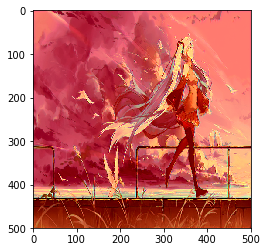

 20%|█▉        | 200/1001 [02:55<11:18,  1.18it/s]

After 200 criterions:
Total loss:  592.0347900390625
Content loss:  1.8582077026367188
Style loss:  313.3036804199219


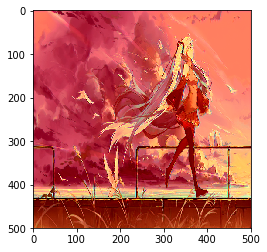

 21%|██        | 208/1001 [03:01<11:11,  1.18it/s]

KeyboardInterrupt: 

In [10]:
for epoch in tqdm(range(0, steps+1)):
    scheduler.step()
    
    target = style_net(content_img).to(device)
    target.requires_grad_(True)
    
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)
    
    style_loss = 0
    
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram_matrix = get_gram_matrix(target_feature)
        style_gram_matrix = style_gram_matrixs[layer]
        
        layer_style_loss = style_weights[layer] * torch.mean((target_gram_matrix - style_gram_matrix) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c*h*w)
        
    total_loss = content_weight * content_loss + style_weight * style_loss
    total_loss_epoch.append(total_loss.item())
    
    style_loss_epoch.append(style_weight * style_loss)
    content_loss_epoch.append(content_weight * content_loss.item())
    
    optim.zero_grad()
    total_loss.backward()
    optim.step()
    
    if epoch % show_every == 0:
        print("After %d criterions:" % epoch)
        print('Total loss: ', total_loss.item())
        print('Content loss: ', content_loss.item())
        print('Style loss: ', style_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

    output_image = target

In [ ]:
# Try for another image
